In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import QuantileTransformer
from datetime import datetime, timedelta
from scipy.stats import norm
import math

# load and process data

In [35]:
src_ip="192.168.74.10"
dataname = "/content/conn.dat"
data = pd.read_csv(dataname, sep='\t')
data.head(), data.shape

(   Unnamed: 0            ts                 uid      id.orig_h  id.orig_p  \
 0           0  1.338423e+09  CQUa354ustOneJxZh1  192.168.88.10     1035.0   
 1           1  1.338423e+09   C05DzHkyLOXv22Cgl  192.168.88.10     1029.0   
 2           2  1.338423e+09  CfS9Sa1DIa3U8O3lMj  192.168.88.10     1041.0   
 3           3  1.338423e+09  CXnvVj1jvpYLBD7iE2  192.168.88.10     1032.0   
 4           4  1.338423e+09  CcEo3v1SklsSmhVg0b  192.168.88.10     1031.0   
 
         id.resp_h  id.resp_p proto service  duration  ...  resp_bytes  \
 0    69.63.148.95       80.0   tcp    http  0.475420  ...     46769.0   
 1         4.2.2.3       53.0   udp     dns  2.878065  ...       224.0   
 2  188.72.248.160       80.0   tcp    http  2.589537  ...    177641.0   
 3         4.2.2.3       53.0   udp     dns  0.574600  ...       117.0   
 4    50.28.53.156       80.0   tcp    http  7.325680  ...      3540.0   
 
    conn_state local_orig  missed_bytes   history orig_pkts  orig_ip_bytes  \
 0    

In [36]:
today = datetime(2014, 3, 25).date()    # example for experiment
# time range: 2011-07-22, 2014-03-24
startday = today - timedelta(days=977)
endday = today - timedelta(days=1)
print(startday, endday)

2011-07-22 2014-03-24


In [37]:
data.columns.tolist()

['Unnamed: 0',
 'ts',
 'uid',
 'id.orig_h',
 'id.orig_p',
 'id.resp_h',
 'id.resp_p',
 'proto',
 'service',
 'duration',
 'orig_bytes',
 'resp_bytes',
 'conn_state',
 'local_orig',
 'missed_bytes',
 'history',
 'orig_pkts',
 'orig_ip_bytes',
 'resp_pkts',
 'resp_ip_bytes',
 'tunnel_parents']

In [38]:
df_filter = data[['id.orig_h', 'id.resp_h', 'duration', 'orig_bytes', 'resp_bytes', 'orig_pkts', 'resp_pkts', 'conn_state', 'ts']]
df_filter.head()

,id.orig_h,id.resp_h,duration,orig_bytes,resp_bytes,orig_pkts,resp_pkts,conn_state,ts
0,192.168.88.10,69.63.148.95,0.475420,264.0,46769.0,28.0,36.0,SF,1.338423e+09
1,192.168.88.10,4.2.2.3,2.878065,132.0,224.0,4.0,4.0,SF,1.338423e+09
2,192.168.88.10,188.72.248.160,2.589537,951.0,177641.0,77.0,134.0,SF,1.338423e+09
3,192.168.88.10,4.2.2.3,0.574600,85.0,117.0,2.0,2.0,SF,1.338423e+09
4,192.168.88.10,50.28.53.156,7.325680,245.0,3540.0,8.0,8.0,RSTO,1.338423e+09


In [39]:
df_filter.isnull().sum()

,0
id.orig_h,0
id.resp_h,0
duration,23662
orig_bytes,23662
resp_bytes,23662
orig_pkts,0
resp_pkts,0
conn_state,0
ts,0


In [40]:
# Replace missing values
df_filter['duration'].fillna('0', inplace = True)
df_filter['orig_bytes'].fillna('0', inplace = True)
df_filter['resp_bytes'].fillna('0', inplace = True)
df_filter.isnull().sum()

<ipython-input-40-1f7cfadef283>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_filter['duration'].fillna('0', inplace = True)
<ipython-input-40-1f7cfadef283>:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_filter['duration'].fillna('0', inplace = True)
<ipython-input-40-1f7cfadef283>:2: SettingWithCopyWarning: 
A value is trying to be set on a 

,0
id.orig_h,0
id.resp_h,0
duration,0
orig_bytes,0
resp_bytes,0
orig_pkts,0
resp_pkts,0
conn_state,0
ts,0


In [41]:
df_filter.dtypes

,0
id.orig_h,object
id.resp_h,object
duration,object
orig_bytes,object
resp_bytes,object
orig_pkts,float64
resp_pkts,float64
conn_state,object
ts,float64


In [42]:
# convert 'duration...' type to 'int'
df_filter['duration'], df_filter['orig_bytes'],df_filter['resp_bytes']  = df_filter['duration'].apply(lambda x: int(x)), df_filter['orig_bytes'].apply(lambda x: int(x)), df_filter['orig_bytes'].apply(lambda x: int(x))
df_filter['orig_pkts'], df_filter['resp_pkts'] = df_filter['orig_pkts'].apply(lambda x: int(x)), df_filter['resp_pkts'].apply(lambda x: int(x))

<ipython-input-42-78b7ccf28cc0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter['duration'], df_filter['orig_bytes'],df_filter['resp_bytes']  = df_filter['duration'].apply(lambda x: int(x)), df_filter['orig_bytes'].apply(lambda x: int(x)), df_filter['orig_bytes'].apply(lambda x: int(x))
<ipython-input-42-78b7ccf28cc0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter['orig_pkts'], df_filter['resp_pkts'] = df_filter['orig_pkts'].apply(lambda x: int(x)), df_filter['resp_pkts'].apply(lambda

In [43]:
# convert 'conn_state' type to 'str'
df_filter['conn_state'] = df_filter['conn_state'].astype(str)

<ipython-input-43-5a0155ac203a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter['conn_state'] = df_filter['conn_state'].astype(str)


In [44]:
df_filter.dtypes

,0
id.orig_h,object
id.resp_h,object
duration,int64
orig_bytes,int64
resp_bytes,int64
orig_pkts,int64
resp_pkts,int64
conn_state,object
ts,float64


In [45]:
df_filter['ts'] = pd.to_datetime(df_filter['ts'], unit='s') # time range: 2011-07-22, 2014-03-24
df_filter['date'] = df_filter['ts'].apply(lambda x: x.date())
df_filter.head()

<ipython-input-45-700e622113b7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter['ts'] = pd.to_datetime(df_filter['ts'], unit='s') # time range: 2011-07-22, 2014-03-24
<ipython-input-45-700e622113b7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter['date'] = df_filter['ts'].apply(lambda x: x.date())


,id.orig_h,id.resp_h,duration,orig_bytes,resp_bytes,orig_pkts,resp_pkts,conn_state,ts,date
0,192.168.88.10,69.63.148.95,0,264,264,28,36,SF,2012-05-31 00:09:29.064680099,2012-05-31
1,192.168.88.10,4.2.2.3,2,132,132,4,4,SF,2012-05-31 00:09:27.018640041,2012-05-31
2,192.168.88.10,188.72.248.160,2,951,951,77,134,SF,2012-05-31 00:09:30.787329912,2012-05-31
3,192.168.88.10,4.2.2.3,0,85,85,2,2,SF,2012-05-31 00:09:28.477570057,2012-05-31
4,192.168.88.10,50.28.53.156,7,245,245,8,8,RSTO,2012-05-31 00:09:28.284359932,2012-05-31


In [46]:
datetime_sorted_unique_index = df_filter['date'].drop_duplicates().sort_values().tolist()
print(datetime_sorted_unique_index, len(datetime_sorted_unique_index)) # 736

[datetime.date(2011, 7, 22), datetime.date(2011, 7, 23), datetime.date(2011, 7, 28), datetime.date(2011, 7, 29), datetime.date(2011, 7, 30), datetime.date(2011, 8, 5), datetime.date(2011, 8, 6), datetime.date(2011, 8, 7), datetime.date(2011, 8, 13), datetime.date(2011, 8, 14), datetime.date(2011, 8, 15), datetime.date(2011, 8, 16), datetime.date(2011, 8, 17), datetime.date(2011, 8, 23), datetime.date(2011, 8, 24), datetime.date(2011, 8, 25), datetime.date(2011, 8, 26), datetime.date(2011, 8, 27), datetime.date(2011, 8, 28), datetime.date(2011, 8, 29), datetime.date(2011, 9, 1), datetime.date(2011, 9, 2), datetime.date(2011, 9, 3), datetime.date(2011, 9, 6), datetime.date(2011, 9, 7), datetime.date(2011, 9, 9), datetime.date(2011, 9, 10), datetime.date(2011, 9, 11), datetime.date(2011, 9, 13), datetime.date(2011, 9, 16), datetime.date(2011, 9, 17), datetime.date(2011, 9, 18), datetime.date(2011, 9, 19), datetime.date(2011, 9, 20), datetime.date(2011, 9, 21), datetime.date(2011, 9, 22), 

In [47]:
df_filter['id.orig_h'].value_counts() # src : 742; dest: 30939; src = 192.168.74.10

,count
id.orig_h,
192.168.74.10,4377
192.168.29.10,3232
192.168.26.10,2991
192.168.2.10,2911
192.168.47.10,2811
...,...
213.206.34.1,1
87.198.71.233,1
109.104.165.146,1


In [48]:
df_filter_scr_ip = df_filter[df_filter['id.orig_h']==src_ip]

df1 = df_filter_scr_ip[['duration', 'orig_bytes', 'resp_bytes',  'orig_pkts',  'resp_pkts', 'date']]
df2 = df_filter_scr_ip[['id.resp_h', 'date']]
df3 = df_filter_scr_ip[['conn_state', 'date']]

# group by date
df1_1 = df1.groupby(['date']).sum()
df1_2 = df1.groupby(['date']).mean()
df1_3 = df1.groupby(['date']).max()

df1_f = pd.DataFrame(index=df1_1.index)

df1_f['duration_tot'], df1_f['duration_ave'], df1_f['duration_max'] = df1_1['duration'], df1_2['duration'], df1_3['duration']
df1_f['orig_bytes_tot'], df1_f['orig_bytes_ave'], df1_f['orig_bytes_max'] = df1_1['orig_bytes'], df1_2['orig_bytes'], df1_3['orig_bytes']
df1_f['resp_bytes_tot'], df1_f['resp_bytes_ave'], df1_f['resp_bytes_max'] = df1_1['resp_bytes'], df1_2['resp_bytes'], df1_3['resp_bytes']
df1_f['orig_pkts_tot'], df1_f['orig_pkts_ave'], df1_f['orig_pkts_max'] = df1_1['orig_pkts'], df1_2['orig_pkts'], df1_3['orig_pkts']
df1_f['resp_pkts_tot'], df1_f['resp_pkts_ave'], df1_f['resp_pkts_max'] = df1_1['resp_pkts'], df1_2['resp_pkts'], df1_3['resp_pkts']
df1_f.head()

,duration_tot,duration_ave,duration_max,orig_bytes_tot,orig_bytes_ave,orig_bytes_max,resp_bytes_tot,resp_bytes_ave,resp_bytes_max,orig_pkts_tot,orig_pkts_ave,orig_pkts_max,resp_pkts_tot,resp_pkts_ave,resp_pkts_max
date,,,,,,,,,,,,,,,
2011-08-17,861,5.937931,35,14550,100.344828,1919,14550,100.344828,1919,660,4.551724,195,525,3.620690,289
2011-09-10,251,0.731778,60,168507,491.274052,1520,168507,491.274052,1520,3555,10.364431,277,4350,12.682216,392
2011-10-03,334,7.767442,64,21853,508.209302,3904,21853,508.209302,3904,930,21.627907,265,1294,30.093023,401
2011-10-09,458,13.878788,63,43862,1329.151515,9039,43862,1329.151515,9039,1407,42.636364,423,1995,60.454545,627
2011-10-18,148,10.571429,62,8857,632.642857,2433,8857,632.642857,2433,649,46.357143,208,942,67.285714,313


In [49]:
df2_f = df2.groupby(['date']).nunique()
df2_f.head()

,id.resp_h
date,
2011-08-17,24
2011-09-10,25
2011-10-03,18
2011-10-09,14
2011-10-18,8


In [50]:
date_sorted_unique_index = df_filter['date'].drop_duplicates().sort_values().tolist()
len(date_sorted_unique_index), date_sorted_unique_index

(736,
 [datetime.date(2011, 7, 22),
  datetime.date(2011, 7, 23),
  datetime.date(2011, 7, 28),
  datetime.date(2011, 7, 29),
  datetime.date(2011, 7, 30),
  datetime.date(2011, 8, 5),
  datetime.date(2011, 8, 6),
  datetime.date(2011, 8, 7),
  datetime.date(2011, 8, 13),
  datetime.date(2011, 8, 14),
  datetime.date(2011, 8, 15),
  datetime.date(2011, 8, 16),
  datetime.date(2011, 8, 17),
  datetime.date(2011, 8, 23),
  datetime.date(2011, 8, 24),
  datetime.date(2011, 8, 25),
  datetime.date(2011, 8, 26),
  datetime.date(2011, 8, 27),
  datetime.date(2011, 8, 28),
  datetime.date(2011, 8, 29),
  datetime.date(2011, 9, 1),
  datetime.date(2011, 9, 2),
  datetime.date(2011, 9, 3),
  datetime.date(2011, 9, 6),
  datetime.date(2011, 9, 7),
  datetime.date(2011, 9, 9),
  datetime.date(2011, 9, 10),
  datetime.date(2011, 9, 11),
  datetime.date(2011, 9, 13),
  datetime.date(2011, 9, 16),
  datetime.date(2011, 9, 17),
  datetime.date(2011, 9, 18),
  datetime.date(2011, 9, 19),
  datetime.da

In [51]:
# all possible sig_ids
conn_states = ['S0','S1','REJ']

dates = []
startDate = startday
endDate = endday
addDays = timedelta(days=1)
while startDate <= endDate:
    dates.append(startDate)
    startDate += addDays

In [52]:
new_df3 = pd.DataFrame(columns = conn_states, index = date_sorted_unique_index)

startDate = startday
endDate = endday
addDays = timedelta(days=1)

while startDate <= endDate:
    day = startDate
    if day in date_sorted_unique_index:
        filt_df = df_filter[df_filter['date'] == day]
        cnts = filt_df['conn_state'].value_counts()
        for x in conn_states:
            if x in cnts.keys():
                new_df3.loc[day, x] = cnts[x]
            else:
                new_df3.loc[day, x] = 0

    startDate += addDays

# pd.set_option('max_columns', None)
new_df3.head(), new_df3.shape

(            S0  S1 REJ
 2011-07-22  33   3   0
 2011-07-23  14   0   0
 2011-07-28   6   4   0
 2011-07-29  14   0   0
 2011-07-30  32  31   0,
 (736, 3))

In [53]:
df3_f = new_df3.copy()

In [55]:
# combine df1, df2
new_df = pd.concat([df2_f, df1_f, df3_f], axis=1)
new_df.head()

,id.resp_h,duration_tot,duration_ave,duration_max,orig_bytes_tot,orig_bytes_ave,orig_bytes_max,resp_bytes_tot,resp_bytes_ave,resp_bytes_max,orig_pkts_tot,orig_pkts_ave,orig_pkts_max,resp_pkts_tot,resp_pkts_ave,resp_pkts_max,S0,S1,REJ
2011-08-17,24.0,861.0,5.937931,35.0,14550.0,100.344828,1919.0,14550.0,100.344828,1919.0,660.0,4.551724,195.0,525.0,3.620690,289.0,30,0,0
2011-09-10,25.0,251.0,0.731778,60.0,168507.0,491.274052,1520.0,168507.0,491.274052,1520.0,3555.0,10.364431,277.0,4350.0,12.682216,392.0,44,74,0
2011-10-03,18.0,334.0,7.767442,64.0,21853.0,508.209302,3904.0,21853.0,508.209302,3904.0,930.0,21.627907,265.0,1294.0,30.093023,401.0,8,6,0
2011-10-09,14.0,458.0,13.878788,63.0,43862.0,1329.151515,9039.0,43862.0,1329.151515,9039.0,1407.0,42.636364,423.0,1995.0,60.454545,627.0,219,135,35
2011-10-18,8.0,148.0,10.571429,62.0,8857.0,632.642857,2433.0,8857.0,632.642857,2433.0,649.0,46.357143,208.0,942.0,67.285714,313.0,23,3,0


In [56]:
new_df.shape

(736, 19)

In [32]:
file_name = "/content/{}_processed_data_src.csv".format(src_ip)
new_df.to_csv(file_name, index=True, date_format='%Y-%m-%d')

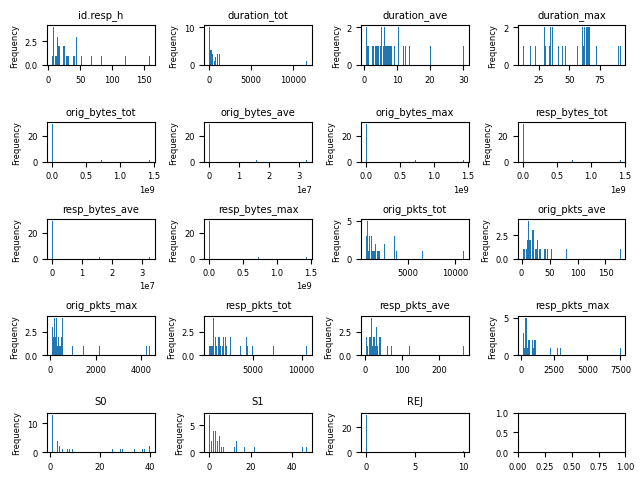

In [33]:
# Plot distribution before transform
X_plot = new_df.copy()
plt.rcParams.update({'font.size': 6})
figure, axis = plt.subplots(5, 4)
for i in range(len(X_plot.columns)):
    X_plot[X_plot.columns[i]].plot(ax=axis[i//4,i%4], kind='hist', bins=100, title=X_plot.columns[i])
plt.tight_layout()
file_name = "/content/{}_distribution_before_transform_plot.svg".format(src_ip)
plt.savefig(file_name)
plt.show()

# train and evaluation model

In [60]:
# Specify the source ip
src_ip="192.168.74.10"

# specify the threshold percentile.
th_perc = 10

# Print the alerts table. 0 means including training and testing data, 1 means only has training data.
flag = 0

In [61]:
filename = "/content/{}_processed_data_src.csv".format(src_ip)
new_df = pd.read_csv(filename, index_col=0, parse_dates=True)
new_df.head()

,id.resp_h,duration_tot,duration_ave,duration_max,orig_bytes_tot,orig_bytes_ave,orig_bytes_max,resp_bytes_tot,resp_bytes_ave,resp_bytes_max,orig_pkts_tot,orig_pkts_ave,orig_pkts_max,resp_pkts_tot,resp_pkts_ave,resp_pkts_max,S0,S1,REJ
2011-08-17,24,861,5.937931,35,14550,100.344828,1919,14550,100.344828,1919,660,4.551724,195,525,3.620690,289,29,0,0
2011-09-10,25,251,0.731778,60,168507,491.274052,1520,168507,491.274052,1520,3555,10.364431,277,4350,12.682216,392,1,17,0
2011-10-03,18,334,7.767442,64,21853,508.209302,3904,21853,508.209302,3904,930,21.627907,265,1294,30.093023,401,1,2,0
2011-10-09,14,458,13.878788,63,43862,1329.151515,9039,43862,1329.151515,9039,1407,42.636364,423,1995,60.454545,627,1,13,0
2011-10-18,8,148,10.571429,62,8857,632.642857,2433,8857,632.642857,2433,649,46.357143,208,942,67.285714,313,1,1,0


In [62]:
new_df.shape

(31, 19)

In [63]:
type(new_df.index[0])

pandas._libs.tslibs.timestamps.Timestamp

In [64]:
# Split the training and prediction sets: Time range: 2011-07-22 to 2014-03-24
cut = datetime(2013, 7, 1).date()     # First day to predict
loc = new_df.index.slice_locs(end=cut)
train_df = new_df.iloc[loc[0]:loc[1], :]
predict_df = new_df.iloc[loc[1]:, :]

In [65]:
X = train_df.copy()
qt_transformer = QuantileTransformer(output_distribution='normal')
qt_transformer.fit(X)
X_qt = qt_transformer.transform(X)
X_qt = pd.DataFrame(data=X_qt, index=X.index, columns=X.columns)

X_qt.shape

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (27). n_quantiles is set to n_samples.
  warnings.warn(


(27, 19)

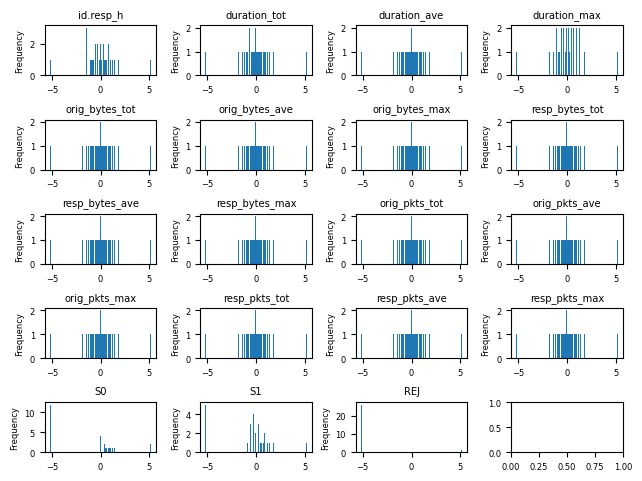

In [66]:
# Plot distribution after transform
X_plot = X_qt
plt.rcParams.update({'font.size': 6})
figure, axis = plt.subplots(5, 4)
for i in range(len(X_plot.columns)):
    X_plot[X_plot.columns[i]].plot(ax=axis[i//4,i%4], kind='hist', bins=100, title=X_plot.columns[i])
plt.tight_layout()
file_name = "/content/{}_distribution_after_transform_plot.svg".format(src_ip)
plt.savefig(file_name)
plt.show()

### Compute anomaly score using probability

In [67]:
# compute probability
stats = X_qt.describe()

probs = pd.DataFrame(index=X_qt.index)
for x in X_qt.columns:
    mu, sigma = stats.loc['mean', x], stats.loc['std', x]
    for i in X_qt.index:
        probs.loc[i, x] = norm.sf(X_qt.loc[i, x], loc=mu, scale=sigma)

In [68]:
# compute log probability
log_probs = pd.DataFrame(index=probs.index)
for x in probs.columns:
    log_probs[x] = probs[x].apply(lambda x: math.log(x))

In [69]:
# compute anomaly score = sum of log probabilities
log_probs['score'] = log_probs.sum(axis=1)

In [70]:
# compute threshold score
th = np.percentile(log_probs['score'], th_perc)

## Prediction

In [71]:
# transform, compute probability, log probability, anomaly score
def probab_score(x, qt_transformer, stats):
    x_tran = qt_transformer.transform(x)
    x_tran = pd.DataFrame(data=x_tran, index=x.index, columns=x.columns)
    x_prob = pd.DataFrame(index=x_tran.index)
    x_log_prob = pd.DataFrame(index=x_tran.index)
    for x in x_tran.columns:
        mu, sigma = stats.loc['mean', x], stats.loc['std', x]
        for i in x_tran.index:
            x_prob.loc[i, x] = norm.sf(x_tran.loc[i, x], loc=mu, scale=sigma)
        x_log_prob[x] = x_prob[x].apply(lambda x: math.log(x))

    x_log_prob['score'] = x_log_prob.sum(axis=1)

    return x_tran, x_prob, x_log_prob

In [81]:
x = predict_df.copy()
# x = train_df.copy()
x_tran, x_prob, x_log_prob = probab_score(x, qt_transformer, stats)

In [82]:
def alert_tb(src, x, x_tran, x_prob, x_log_prob, th, th_perc, qt_transformer, stats):
    # th, th_perc: threshold, threshold percentile

    mu_std = qt_transformer.inverse_transform(stats.loc[['mean', 'std'], :])
    mu_std = pd.DataFrame(data=mu_std, index=['mean', 'std'], columns=stats.columns)


    tb_list = []     # list of tables, one for each anomaly
    for i in x.index:
        # print(i)
        tbi = pd.DataFrame(index=['data', 'mean', 'std', 'transformed data',
                                  'transformed mean', 'transformed std', 'probability'])
        for row in tbi.index[:1]:
            tbi.loc[row, 'src'] = src
            tbi.loc[row, 'date'] = i

            tbi.loc[row, 'score'] = f"{x_log_prob.loc[i, 'score']:.2f}"
            tbi.loc[row, 'score_th'] = f"{th:.2f}"
            tbi.loc[row, 'th_perc'] = th_perc

        for col in x.columns:
            # print(col)
            tbi.loc['data', col] = f"{x.loc[i, col]:.2f}"
            tbi.loc['data', "{}_↑_%".format(col)] = np.nan
            tbi.loc['data', "{}_↑abs_value".format(col)] = np.nan
            if mu_std.loc['mean', col] != 0:
                tbi.loc['data', "{}_↑_%".format(col)] = "{}%".format(round((x.loc[i, col] - mu_std.loc['mean', col]) / mu_std.loc['mean', col] * 100, 2))
            else:
                tbi.loc['data', "{}_↑abs_value".format(col)] = f"{abs(x.loc[i, col] - mu_std.loc['mean', col]):.2f}"
            tbi.loc['mean', col] = f"{mu_std.loc['mean', col]:.2f}"
            tbi.loc['std', col] = f"{mu_std.loc['std', col]:.2f}"
            tbi.loc['transformed data', col] = f"{x_tran.loc[i, col]:.2f}"
            tbi.loc['transformed mean', col] = f"{stats.loc['mean', col]:.2f}"
            tbi.loc['transformed std', col] = f"{stats.loc['std', col]:.2f}"
            tbi.loc['probability', col] = f"{x_prob.loc[i, col]:.2f}"

        tb_list.append(tbi)
    tb = pd.concat(tb_list)
    return tb

In [86]:
anom_ind = x_log_prob[x_log_prob['score'] < th].index
if not anom_ind.empty:
    tb = alert_tb(src_ip, x.loc[anom_ind, :], x_tran.loc[anom_ind, :], x_prob.loc[anom_ind, :], \
                  x_log_prob.loc[anom_ind, :], th, th_perc, qt_transformer, stats)
else:
    tb = "No anomaly found."

<ipython-input-82-84fbac92240e>:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '590.0%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  tbi.loc['data', "{}_↑_%".format(col)] = "{}%".format(round((x.loc[i, col] - mu_std.loc['mean', col]) / mu_std.loc['mean', col] * 100, 2))
<ipython-input-82-84fbac92240e>:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3367.06%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  tbi.loc['data', "{}_↑_%".format(col)] = "{}%".format(round((x.loc[i, col] - mu_std.loc['mean', col]) / mu_std.loc['mean', col] * 100, 2))
<ipython-input-82-84fbac92240e>:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '389.84%' has dtype incompatib

In [87]:
tb.head()

,src,date,score,score_th,th_perc,id.resp_h,id.resp_h_↑_%,id.resp_h_↑abs_value,duration_tot,duration_tot_↑_%,...,resp_pkts_max_↑abs_value,S0,S0_↑_%,S0_↑abs_value,S1,S1_↑_%,S1_↑abs_value,REJ,REJ_↑_%,REJ_↑abs_value
data,192.168.74.10,2013-11-30,-57.50,-31.52,10.0,159.00,590.0%,NaN,11582.00,3367.06%,...,NaN,5.00,400.0%,NaN,0.00,-100.0%,NaN,0.00,NaN,0.00
mean,NaN,NaT,NaN,NaN,NaN,23.04,NaN,NaN,334.06,NaN,...,NaN,1.00,NaN,NaN,2.00,NaN,NaN,0.00,NaN,NaN
std,NaN,NaT,NaN,NaN,NaN,79.82,NaN,NaN,1272.88,NaN,...,NaN,40.00,NaN,NaN,46.69,NaN,NaN,4.10,NaN,NaN
transformed data,NaN,NaT,NaN,NaN,NaN,5.20,NaN,NaN,5.20,NaN,...,NaN,0.42,NaN,NaN,-5.20,NaN,NaN,-5.20,NaN,NaN
transformed mean,NaN,NaT,NaN,NaN,NaN,0.00,NaN,NaN,0.00,NaN,...,NaN,-1.66,NaN,NaN,-0.58,NaN,NaN,-4.81,NaN,NaN


In [ ]:
if isinstance(tb, pd.DataFrame) and not tb.empty:
    file_name = "/content/{}_anomely_tb_src_train_1112.csv".format(src_ip)
    tb.to_csv(file_name)
else:
    print(tb)

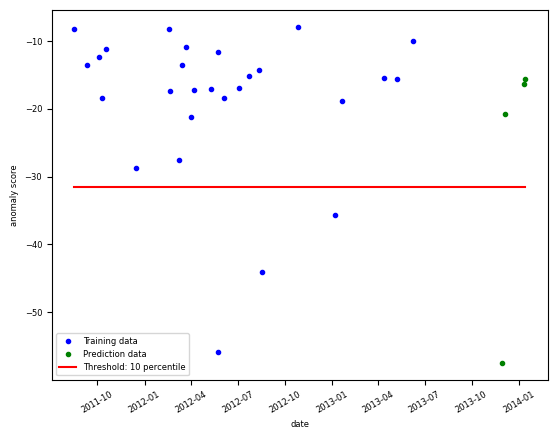

In [85]:
if flag == 0:
    # predict
    x_line = pd.concat([pd.Series(log_probs.index), pd.Series(x_log_prob.index)])
    # th_line = [th] * len(log_probs)
    th_line = [th] * len(x_line)
    plt.xlabel('date')
    plt.ylabel('anomaly score')
    plt.xticks(rotation=30)
    plt.plot(log_probs.index, log_probs['score'], 'b.', label='Training data')
    # plt.plot(log_probs.index, th_line, 'r', label='Threshold: 10 percentile')
    plt.plot(x_log_prob.index, x_log_prob['score'], 'g.', label='Prediction data')
    plt.plot(x_line, th_line, 'r', label='Threshold: 10 percentile')
    plt.legend(loc='lower left')

    file_name = "/content/{}_anomely_plot_1112.svg".format(src_ip)
    plt.savefig(file_name)

    plt.show()

if flag == 1:
    # train
    # plot anomaly score with threshol line
    x_line = pd.concat([pd.Series(log_probs.index), pd.Series(x_log_prob.index)])
    th_line = [th] * len(log_probs)
    # th_line = [th] * len(x_line)
    plt.xlabel('date')
    plt.ylabel('anomaly score')
    plt.xticks(rotation=30)
    plt.plot(log_probs.index, log_probs['score'], 'b.')
    # plt.plot(log_probs.index, log_probs['score'], 'b.', label='Training data')
    plt.plot(log_probs.index, th_line, 'r', label='Threshold: 10 percentile')
    # plt.plot(x_log_prob.index, x_log_prob['score'], 'g.', label='Prediction data')
    # plt.plot(x_line, th_line, 'r', label='Threshold: 10 percentile')
    plt.legend(loc='lower right') # , plt.legend(loc='lower right', bbox_to_anchor=(1.5, 0.0))

    file_name = "/content/{}_anomely_plot_train_1112.svg".format(src_ip)
    plt.savefig(file_name)

    plt.show()

# seconde model: machine learning based model-IsolationForest model


In [89]:
# Let me first inspect the uploaded file to understand its structure and contents
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Load the dataset
file_path = '/content/192.168.74.10_processed_data_src.csv'
new_df = pd.read_csv(file_path, index_col=0, parse_dates=True)

# Display the first few rows of the dataframe to understand its structure
new_df.head()

,id.resp_h,duration_tot,duration_ave,duration_max,orig_bytes_tot,orig_bytes_ave,orig_bytes_max,resp_bytes_tot,resp_bytes_ave,resp_bytes_max,orig_pkts_tot,orig_pkts_ave,orig_pkts_max,resp_pkts_tot,resp_pkts_ave,resp_pkts_max,S0,S1,REJ
2011-08-17,24,861,5.937931,35,14550,100.344828,1919,14550,100.344828,1919,660,4.551724,195,525,3.620690,289,29,0,0
2011-09-10,25,251,0.731778,60,168507,491.274052,1520,168507,491.274052,1520,3555,10.364431,277,4350,12.682216,392,1,17,0
2011-10-03,18,334,7.767442,64,21853,508.209302,3904,21853,508.209302,3904,930,21.627907,265,1294,30.093023,401,1,2,0
2011-10-09,14,458,13.878788,63,43862,1329.151515,9039,43862,1329.151515,9039,1407,42.636364,423,1995,60.454545,627,1,13,0
2011-10-18,8,148,10.571429,62,8857,632.642857,2433,8857,632.642857,2433,649,46.357143,208,942,67.285714,313,1,1,0


In [90]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split data into training and testing sets
cut = datetime(2013, 7, 1).date()     # First day to predict
loc = new_df.index.slice_locs(end=cut)
train_df = new_df.iloc[loc[0]:loc[1], :]
predict_df = new_df.iloc[loc[1]:, :]

# Extract features for model training
X_train = train_df.copy()
X_test = predict_df.copy()

In [92]:
# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [96]:
# Train an Isolation Forest model
iso_forest = IsolationForest(contamination=0.1, random_state=42)
iso_forest.fit(X_train_scaled)

IsolationForest(contamination=0.1, random_state=42)

In [102]:
train_predictions = iso_forest.predict(X_train_scaled)
train_df['anomaly'] = train_predictions

<ipython-input-102-1c7ea57a3db0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['anomaly'] = train_predictions


In [103]:
# Predict anomalies on the test set
test_predictions = iso_forest.predict(X_test_scaled)

In [104]:
# Label anomalies (-1) and normal events (1)
predict_df['anomaly'] = test_predictions

<ipython-input-104-d412980014ef>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_df['anomaly'] = test_predictions


In [105]:
predict_df

,id.resp_h,duration_tot,duration_ave,duration_max,orig_bytes_tot,orig_bytes_ave,orig_bytes_max,resp_bytes_tot,resp_bytes_ave,resp_bytes_max,orig_pkts_tot,orig_pkts_ave,orig_pkts_max,resp_pkts_tot,resp_pkts_ave,resp_pkts_max,S0,S1,REJ,anomaly
2013-11-30,159,11582,30.161458,92,460103,1198.184896,18219,460103,1198.184896,18219,10931,28.466146,4371,7056,18.375000,2992,5,0,0,-1
2013-12-05,14,1011,9.448598,90,37004,345.831776,1655,37004,345.831776,1655,3569,33.355140,384,4370,40.841121,522,1,1,0,1
2014-01-12,28,283,6.288889,67,29107,646.822222,11817,29107,646.822222,11817,1065,23.666667,380,1475,32.777778,558,7,2,0,1
2014-01-14,30,1277,5.298755,56,68640,284.813278,9209,68640,284.813278,9209,1939,8.045643,557,2005,8.319502,1053,25,0,0,1


In [106]:
# Add anomaly labels to the datasets
train_df['anomaly'] = train_predictions
predict_df['anomaly'] = test_predictions

<ipython-input-106-d7d07bc6398c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['anomaly'] = train_predictions
<ipython-input-106-d7d07bc6398c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_df['anomaly'] = test_predictions


In [107]:
# Combine train and test results for overall evaluation
combined_df = pd.concat([train_df, predict_df])

# Calculate anomaly ratios for both train and test sets
train_anomaly_ratio = (train_predictions == -1).mean()
test_anomaly_ratio = (test_predictions == -1).mean()

In [108]:
evaluation_summary = {
    'Train Anomaly Ratio': train_anomaly_ratio,
    'Test Anomaly Ratio': test_anomaly_ratio,
    'Total Anomalies in Train Set': (train_predictions == -1).sum(),
    'Total Anomalies in Test Set': (test_predictions == -1).sum()
}

In [109]:
evaluation_summary

{'Train Anomaly Ratio': 0.1111111111111111,
 'Test Anomaly Ratio': 0.25,
 'Total Anomalies in Train Set': 3,
 'Total Anomalies in Test Set': 1}